## Assignment 3: $k$ Nearest Neighbor and $k$ Means Clustering

## **Do three questions.**

`! git clone https://www.github.com/DS3001/assignment3`

In [1]:
! git clone https://www.github.com/DS3001/assignment3

fatal: destination path 'assignment3' already exists and is not an empty directory.


In [2]:
import pandas as pd
import numpy as np

**Q1.** This question is a case study for $k$ nearest neighbor. The target variable `y` is `Purchase` and the features of interest are `Age` and `AnnualSalary`.

1. Load the `./data/car_data.csv` data. Look at the head and dimensions of the data.
2. Summarize the variables (`User.ID`, `Gender`, `Age`, `AnnualSalary`, `Purchase`). Are there any missings to clean? Convert the `Gender` categorical variable into a dummy variable that takes the value 0 for male and 1 for female. Create a matrix $X$ of predictors including `Age` and `AnnualSalary`, and an outcome $y$ equaling `Purchase`.
3. MaxMin-normalize `Age` and `AnnualSalary` in `X`.
4. Split the sample into a ~80% training dataset and a ~20% testing dataset.
5. Treat this as a classification problem: The model is supposed to predict 0 or 1 for each customer, classifying them as a purchaser or non-purchaser. Use sklearn to determine the optimal number of neighbors $k$ to use.
6. Run the model for the optimal number of neighbors on the testing data. Cross tabulate the predicted outcomes against the actual outcomes; this is called a **confusion matrix**. How often does the model predict a sale when one fails to occur? How often does the model predict no sale when one does occur? Overall, does it provide accurate predictions?
7. Now, compute confusion matrices separately for men and women, as in part 6. Does the model make more accurate predictions for one sex or the other? Explain. (Performance of algorithms on population subgroups is a growing topic in data science.)

In [4]:
# 1. Load the ./data/car_data.csv data. Look at the head and dimensions of the data.
cars = pd.read_csv("assignment3/data/car_data.csv")

In [5]:
# Summarize the variables (User.ID, Gender, Age, AnnualSalary, Purchase).
# Are there any missings to clean?
print(cars.dtypes, "\n")
for col in cars.columns:
  print(cars[col].isnull().sum() + cars[col].isna().sum())
  if col != "User ID":
    print(cars[col].unique(),"\n")
print(cars.describe())

User ID          int64
Gender          object
Age              int64
AnnualSalary     int64
Purchased        int64
dtype: object 

0
0
['Male' 'Female'] 

0
[35 40 49 25 47 46 42 30 41 32 27 33 39 54 31 24 48 38 45 37 44 26 21 59
 43 28 51 55 23 50 20 58 34 57 53 36 60 29 61 18 62 22 63 52 56 19] 

0
[ 20000  43500  74000 107500  79000  33500 132500  64000  84500  52000
  80000  23000  72500  57000 108000 149000  75000  53000 134000  51500
  39000  25500  61500 117500  58000 107000  97500  29000 147500  26000
  67500  62000  79500 113500  41500  55000 114500  73000  15000  37500
  39500  66500  80500  86000  76500 123000  48500  60500  99500  35500
 130000  56500  36000  21500  98500  59500 147000 109500  26500  88000
  22000  71000 129000  45000  42000  40500  86500  63000 115500  55500
  32500 106500  53500  28000 151500  88500  17000  76000 136500 120500
  44500  18500  50000 144500  51000  38500 103500  75500  87000  84000
  16000  29500  44000  30000  83000 108500 112000 143000  6

Because there are no null or na values in any of the columns, there are no missing values to clean.

In [6]:
# Convert the Gender categorical variable into a dummy variable that takes the
# value 0 for male and 1 for female.
cars["GenderDummy"] = (cars["Gender"] == "Female") + 0 # plus 0 is my hack for forcing the boolean to become a number

In [7]:
cars.head(10)

,User ID,Gender,Age,AnnualSalary,Purchased,GenderDummy
0,385,Male,35,20000,0,0
1,681,Male,40,43500,0,0
2,353,Male,49,74000,0,0
3,895,Male,40,107500,1,0
4,661,Male,25,79000,0,0
5,846,Female,47,33500,1,1
6,219,Female,46,132500,1,1
7,588,Male,42,64000,0,0
8,85,Female,30,84500,0,1
9,465,Male,41,52000,0,0


In [56]:
# Create a matrix X of predictors including Age and AnnualSalary, and an outcome
# y equaling Purchase.
cars_x = cars.drop(["Purchased", "User ID", "Gender"], axis=1)

In [57]:
cars_y = cars["Purchased"]

In [58]:
cars_x.head()

,Age,AnnualSalary,GenderDummy
0,35,20000,0
1,40,43500,0
2,49,74000,0
3,40,107500,0
4,25,79000,0


In [59]:
# 3. MaxMin-normalize Age and AnnualSalary in X.

In [16]:
# Maxmin normalization function:
def maxmin(z):
    z = (z-min(z))/(max(z)-min(z))
    return(z)

In [61]:
cars_x = cars_x.apply(maxmin)

In [69]:
cars_x.head()

,Age,AnnualSalary,GenderDummy
0,0.377778,0.036364,0.0
1,0.488889,0.207273,0.0
2,0.688889,0.429091,0.0
3,0.488889,0.672727,0.0
4,0.155556,0.465455,0.0


In [63]:
# Split the sample into a ~80% training dataset and a ~20% testing dataset.
from sklearn.model_selection import train_test_split

In [64]:
X_train, X_test, y_train, y_test = train_test_split(cars_x, cars_y,test_size=.2,random_state=100)

In [65]:
# Treat this as a classification problem:
# The model is supposed to predict 0 or 1 for each customer, classifying them as
# a purchaser or non-purchaser. Use sklearn to determine the optimal number of
# neighbors k to use.

In [72]:
# this code modified from the knn notebook in the DS3001 GitHub repo
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

k_bar = 50
k_grid = np.arange(1,k_bar)
SSE_train = np.zeros(k_bar)
SSE_test = np.zeros(k_bar)
for k in range(k_bar):
    model = KNeighborsClassifier(n_neighbors=k+1) # Create a sk model for k
    fitted_model = model.fit(X_train,y_train) # Train the model on our data
    y_hat = fitted_model.predict(X_test) # Predict values for test set
    SSE_test[k] = np.sum( (y_test-y_hat)**2 ) # Save the computed SSE
    y_hat = fitted_model.predict(X_train) # Predict values for training set
    SSE_train[k] = np.sum( (y_train-y_hat)**2 ) # Save the computed SSE


In [78]:
SSE_min = np.min(SSE_test) # Lowest recorded SSE
print(SSE_min)
min_index = np.where(SSE_test==SSE_min) # Find the indices of y that equal the minimum
print(min_index[0][0]) # min_index is a tuple, so grab the first element in it
k_star = k_grid[min_index[0][0]] # Find the optimal value of k

14.0
7


In [79]:
print(k_star)

8


In [80]:
# Run the model for the optimal number of neighbors on the testing data.
best_model = KNeighborsClassifier(n_neighbors=k_star)
best_fitted_model = best_model.fit(X_train, y_train)
y_hat = best_fitted_model.predict(X_test)

In [81]:
y_hat

array([1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1,
       0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0,
       1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0,
       1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0,
       0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0,
       1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1,
       1, 0])

In [88]:
# Cross tabulate the predicted outcomes against the actual outcomes;
# this is called a confusion matrix.
# How often does the model predict a sale when one fails to occur?
# How often does the model predict no sale when one does occur?
# Overall, does it provide accurate predictions?

pd.crosstab(index=y_hat, rownames=["Predicted"], colnames=["Actual"], columns=y_test)

Actual,0,1
Predicted,,
0,106,5
1,13,76


The model predicts a sale when one fails to occur (i.e., y_hat is 1 when y_test is 0) 13 out of 200 total predictions, or 6.5% of the time.

The model predicts no sale when one does occur 2.5% of the time.

Overall, it seems that the model provides accurate predictions, because it was correct 91% of the time.

In [89]:
# Now, compute confusion matrices separately for men and women, as in part 6.
# Does the model make more accurate predictions for one sex or the other?
# Explain. (Performance of algorithms on population subgroups is a growing
# topic in data science.)

In [108]:
women_indices = np.where(X_test["GenderDummy"] == 1)

In [103]:
men_indices = np.where(X_test["GenderDummy"] == 0)

In [109]:
y_hat_women = y_hat[women_indices]
y_hat_men = y_hat[men_indices]

In [113]:
y_test_women = y_test.iloc[women_indices]
y_test_men = y_test.iloc[men_indices]

In [115]:
# Women's crosstabulation
pd.crosstab(index=y_hat_women, rownames=["Predicted"], colnames=["Actual"], columns=y_test_women)

Actual,0,1
Predicted,,
0,57,2
1,10,36


Out of 105 total female samples, the model got 93 correct, which means it was correct 88.6% of the time.

In [116]:
# Men's crosstabulation
# Women's crosstabulation
pd.crosstab(index=y_hat_men, rownames=["Predicted"], colnames=["Actual"], columns=y_test_men)

Actual,0,1
Predicted,,
0,49,3
1,3,40


Out of the 95 total male samples, the model got 89 correct, which means it was correct 93.7% of the time. Thus, the model appears to make more accurate predictions for men.

**Q2.** This question is a case study for $k$ nearest neighbor The target variable `y` is `price` and the features are `year` and `mileage`.

1. Load the `./data/USA_cars_datasets.csv`. Keep the following variables and drop the rest: `price`, `year`, `mileage`. Are there any `NA`'s to handle? Look at the head and dimensions of the data.
2. Maxmin normalize `year` and `mileage`.
3. Split the sample into ~80% for training and ~20% for evaluation.
4. Use the $k$NN algorithm for regression and the training data to predict `price` using `year` and `mileage` for the test set for $k=3,10,25,50,100,300$. For each value of $k$, compute the Sum of Squared Error and make a scatterplot showing the test value plotted against the predicted value. What patterns do you notice as you increase $k$?
5. Determine the optimal $k$ for these data.
6. Describe what happened in the plots of predicted versus actual prices as $k$ varied, taking your answer into part 6 into account. (Hint: Use the words "underfitting" and "overfitting".)

**Q3.** This question is a case study for $k$ nearest neighbor, particularly variable selection. The data for the question include (summaries reproduced here directly from the codebook):

- age: age of the patient (years)
- anaemia: decrease of red blood cells or hemoglobin (boolean)
- high blood pressure: if the patient has hypertension (boolean)
- creatinine phosphokinase (CPK): level of the CPK enzyme in the blood (mcg/L)
- diabetes: if the patient has diabetes (boolean)
- ejection fraction: percentage of blood leaving the heart at each contraction (percentage)
- platelets: platelets in the blood (kiloplatelets/mL)
- sex: woman or man (binary)
- serum creatinine: level of serum creatinine in the blood (mg/dL)
- serum sodium: level of serum sodium in the blood (mEq/L)
- smoking: if the patient smokes or not (boolean)
- time: follow-up period (days)
- death event: if the patient deceased during the follow-up period (boolean)

1. Load the `./data/heart_failure_clinical_records_dataset.csv`. Are there any `NA`'s to handle? use `.drop()` to remove `time` from the dataframe.
2. Make a correlation matrix. What variables are strongly associated with a death event?
3. For the dummy variables `anaemia`, `diabetes`, `high_blood_pressure`, `sex`, and `smoking`, compute a summary table of `DEATH_EVENT` grouped by the variable. For which variables does a higher proportion of the population die when the variable takes the value 1 rather than 0?
4. On the basis of your answers from 2 and 3, build a matrix $X$ of the variables you think are most predictive of a death, and a variable $y$ equal to `DEATH_EVENT`.
5. Maxmin normalize all of the variables in `X`.
6. Split the sample into ~80% for training and ~20% for evaluation. (Try to use the same train/test split for the whole question, so that you're comparing apples to apples in the questions below.).
7. Determine the optimal number of neighbors for a $k$NN regression for the variables you selected.
8. OK, do steps 5 through 7 again, but use all of the variables (except `time`). Which model has a lower Sum of Squared Error? Which would you prefer to use in practice, if you had to predict `DEATH_EVENT`s? If you play with the selection of variables, how much does the SSE change for your fitted model on the test data? Are more variables better, in this case? Explain your findings.

**Q4.** Let's do some very basic computer vision. We're going to import the MNIST handwritten digits data and $k$NN to predict values (i.e. "see/read").

1. To load the data, run the following code in a chunk:
```
from keras.datasets import mnist
df = mnist.load_data('minst.db')
train,test = df
X_train, y_train = train
X_test, y_test = test
```
The `y_test` and `y_train` vectors, for each index `i`, tell you want number is written in the corresponding index in `X_train[i]` and `X_test[i]`. The value of `X_train[i]` and `X_test[i]`, however, is a 28$\times$28 array whose entries contain values between 0 and 256. Each element of the matrix is essentially a "pixel" and the matrix encodes a representation of a number. To visualize this, run the following code to see the first ten numbers:
```
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(edgeitems=30, linewidth=100000)
for i in range(5):
    print(y_test[i],'\n') # Print the label
    print(X_test[i],'\n') # Print the matrix of values
    plt.contourf(np.rot90(X_test[i].transpose())) # Make a contour plot of the matrix values
    plt.show()
```
OK, those are the data: Labels attached to handwritten digits encoded as a matrix.

2. What is the shape of `X_train` and `X_test`? What is the shape of `X_train[i]` and `X_test[i]` for each index `i`? What is the shape of `y_train` and `y_test`?
3. Use Numpy's `.reshape()` method to covert the training and testing data from a matrix into an vector of features. So, `X_test[index].reshape((1,784))` will convert the $index$-th element of `X_test` into a $28\times 28=784$-length row vector of values, rather than a matrix. Turn `X_train` into an $N \times 784$ matrix $X$ that is suitable for scikit-learn's kNN classifier where $N$ is the number of observations and $784=28*28$ (you could use, for example, a `for` loop).
4. Use the reshaped `X_test` and `y_test` data to create a $k$-nearest neighbor classifier of digit. What is the optimal number of neighbors $k$? If you can't determine this, play around with different values of $k$ for your classifier.
5. For the optimal number of neighbors, how well does your predictor perform on the test set?
6. So, this is how computers "see." They convert an image into a matrix of values, that matrix becomes a vector in a dataset, and then we deploy ML tools on it as if it was any other kind of tabular data. To make sure you follow this, invent a way to represent a color photo in matrix form, and then describe how you could convert it into tabular data. (Hint: RGB color codes provide a method of encoding a numeric value that represents a color.)

In [3]:
from keras.datasets import mnist
df = mnist.load_data('minst.db')
train,test = df
X_train, y_train = train
X_test, y_test = test

7 

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0  84 185 159 151  60  36   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0 222 254 254 254 254 241 198 198 198 198 198 198 19

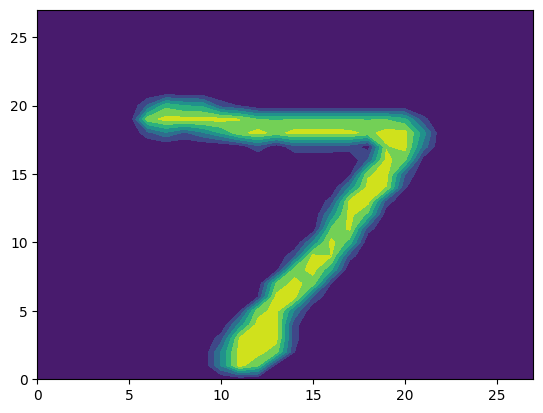

2 

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0 116 125 171 255 255 150  93   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0 169 253 253 253 253 253 253 218  30   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0 169 253 253 253 213 142 176 253 253 122   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0  52 250 253 210  32  12   0   6 206 253 140   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0  77 251 210  25   0   0   0 122 248 253  65   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0  31  18   0   0   0   0 209 253 253  65   

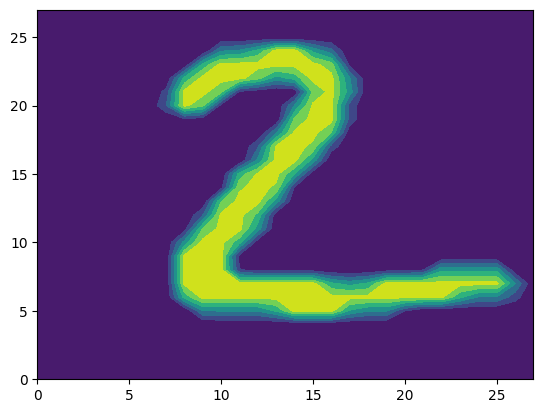

1 

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  38 254 109   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  87 252  82   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 135 241   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  45 244 150   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  84 254  63   

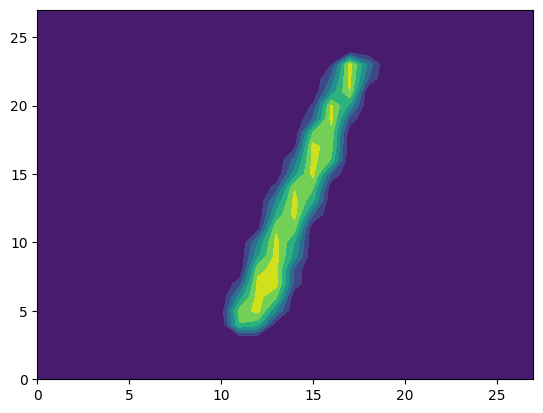

0 

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0  11 150 253 202  31   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0  37 251 251 253 107   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0  21 197 251 251 253 107   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0 110 190 251 251 251 253 169 109  62   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0 253 251 251 251 251 253 251 251 22

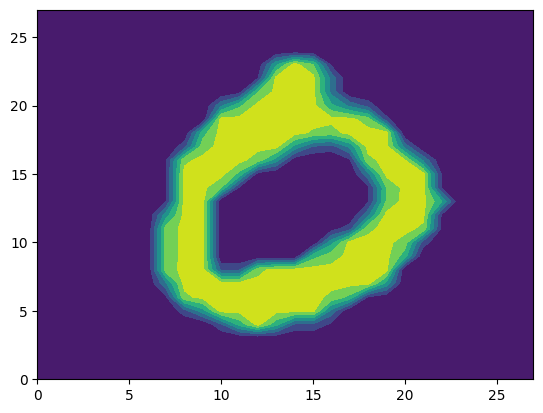

4 

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0  50 224   0   0   0   0   0   0   0  70  29   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0 121 231   0   0   0   0   0   0   0 148 168   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   4 195 231   0   0   0   0   0   0   0  96 210  11   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0  69 252 134   0   0   0   0   0   0   

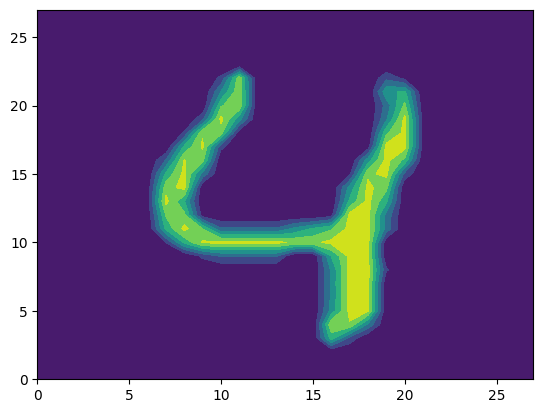

In [4]:
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(edgeitems=30, linewidth=100000)
for i in range(5):
 print(y_test[i],'\n') # Print the label
 print(X_test[i],'\n') # Print the matrix of values
 plt.contourf(np.rot90(X_test[i].transpose())) # Make a contour plot of the matrix values
 plt.show()

In [4]:
# What is the shape of X_train and X_test?
# What is the shape of X_train[i] and X_test[i] for each index i?
# What is the shape of y_train and y_test?

In [5]:
print(X_train.shape)
print(X_test.shape)

(60000, 28, 28)
(10000, 28, 28)


In [6]:
shapes = set()
for i in range(len(X_train)):
  shapes.add(X_train[i].shape)
for i in range(len(X_test)):
  shapes.add(X_test[i].shape)

print(shapes)

{(28, 28)}


The shape of X_train[i] and X_test[i] is (28, 28) for each i.

In [7]:
print(y_train.shape)
print(y_test.shape)

(60000,)
(10000,)


In [8]:
# Use Numpy's .reshape() method to covert the training and testing data from a
# matrix into an vector of features.
# So, X_test[index].reshape((1,784)) will convert the  index-th element of
# X_test into a  28×28=784-length row vector of values, rather than a matrix.
# Turn X_train into an  N×784  matrix  X  that is suitable for scikit-learn's
# kNN classifier where  N  is the number of observations and  784=28∗28
 # (you could use, for example, a for loop).

In [5]:
shaped_train = np.empty((len(X_train), 784))
shaped_test = np.empty((len(X_test), 784))
for i in range(len(X_train)):
  shaped_train[i] = X_train[i].reshape((1,784))
for i in range(len(X_test)):
  shaped_test[i] = X_test[i].reshape((1,784))

X_train = shaped_train
X_test = shaped_test
print(X_train.shape)
print(X_test.shape)

(60000, 784)
(10000, 784)


In [10]:
# Use the reshaped X_test and y_test data to create a  k-nearest neighbor
# classifier of digit. What is the optimal number of neighbors k?
# If you can't determine this, play around with different values of k
# for your classifier.

In [6]:
# this code modified from the knn notebook in the DS3001 GitHub repo
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

k_bar = 10
k_grid = np.arange(1,k_bar)
SSE_train = np.zeros(k_bar)
SSE_test = np.zeros(k_bar)
for k in range(k_bar):
    print(k+1)
    model = KNeighborsClassifier(n_neighbors=k+1) # Create a sk model for k
    fitted_model = model.fit(X_train,y_train) # Train the model on our data
    y_hat = fitted_model.predict(X_test) # Predict values for test set
    SSE_test[k] = np.sum( (y_test-y_hat)**2 ) # Save the computed SSE

1
2
3
4
5
6
7
8
9
10


In [9]:
SSE_min = np.min(SSE_test) # Lowest recorded SSE
print(SSE_min)
min_index = np.where(SSE_test==SSE_min) # Find the indices of y that equal the minimum
print(min_index) # min_index is a tuple, so grab the first element in it
k_star = k_grid[min_index[0][0]] # Find the optimal value of k

5418.0
(array([0]),)


In [8]:
print(k_star)

1


The optimal number of neighbors appears to be one.

In [ ]:
# For the optimal number of neighbors, how well does your predictor
# perform on the test set?

In [10]:
best_model = KNeighborsClassifier(n_neighbors=k_star)
best_fitted_model = best_model.fit(X_train, y_train)
y_hat = best_fitted_model.predict(X_test)

In [11]:
pd.crosstab(index=y_hat, rownames=["Predicted"], columns=y_test, colnames=["Actual"])

Actual,0,1,2,3,4,5,6,7,8,9
Predicted,,,,,,,,,,
0,973,0,7,0,0,1,4,0,6,2
1,1,1129,6,1,7,1,2,14,1,5
2,1,3,992,2,0,0,0,6,3,1
3,0,0,5,970,0,12,0,2,14,6
4,0,1,1,1,944,2,3,4,5,10
5,1,1,0,19,0,860,5,0,13,5
6,3,1,2,0,3,5,944,0,3,1
7,1,0,16,7,5,1,0,992,4,11
8,0,0,3,7,1,6,0,0,920,1


In [14]:
count_correct = 0
for i in range(len(y_hat)):
  if y_hat[i] == y_test[i]:
    count_correct+=1

print(count_correct)
print(len(y_hat))
print(count_correct/len(y_hat))

9691
10000
0.9691


For the optimal number of neighbors, the model correctly classifies the mnist digits at a rate of 96.91%, which seems pretty good.

In [ ]:
# So, this is how computers "see." They convert an image into a matrix of
# values, that matrix becomes a vector in a dataset, and then we deploy ML
# tools on it as if it was any other kind of tabular data.
# To make sure you follow this, invent a way to represent a color photo in
# matrix form, and then describe how you could convert it into tabular data.
# (Hint: RGB color codes provide a method of encoding a numeric value that
# represents a color.)

To represent a color image, I would overlay three 2D matrices. Each cell in the matrices would represent the pixels in the image, and each matrix would hold one value of the RGB triple for each pizel. So, one matrix would hold all the R values, one would hold all the G values, and the thirs would hold all the B values. I could reshape each of these matrices to be a single vector (so, many rows but a single column), and then I could concatenate all three vectors to make one long vector. In that way, I could take all the information about the picture -- the color of each pixel -- and represent it in tabular form.

**Q5.** This question is a case study for $k$ means clustering.

1. Load the `airbnb_hw.csv` data. Clean `Price` along with `Beds`, `Number of Reviews`, and `Review Scores Rating`.
2. Maxmin normalize the data and remove any `nan`'s (`KMeans` from `sklearn` doesn't accept `nan` input).
3. Use `sklearn`'s `KMeans` module to cluster the data by `Beds`, `Number of Reviews`, and `Review Scores Rating` for `k=6`.
4. Use `seaborn`'s `.pairplot()` to make a grid of scatterplots that show how the clustering is carried out in multiple dimensions.
5. Use `.groupby` and `.describe` to compute the average price for each cluster. Which clusters have the highest rental prices?
6. Use a scree plot to pick the number of clusters and repeat steps 4 and 5.

**Q6.** This is a question about $k$ means clustering. We want to investigate how adjusting the "noisiness" of the data impacts the quality of the algorithm and the difficulty of picking $k$.

1. Run the code below, which creates four datasets: `df0_125`, `df0_25`, `df0_5`, `df1_0`, and `df2_0`. Each data set is created by increasing the amount of `noise` (standard deviation) around the cluster centers, from `0.125` to `0.25` to `0.5` to `1.0` to `2.0`.

```
import numpy as np
import pandas as pd

def createData(noise,N=50):
    np.random.seed(100) # Set the seed for replicability
    # Generate (x1,x2,g) triples:
    X1 = np.array([np.random.normal(1,1,N),np.random.normal(1,1,N)])
    X2 = np.array([np.random.normal(3,1,N),np.random.normal(2,1,N)])
    X3 = np.array([np.random.normal(5,1,N),np.random.normal(3,1,N)])
    # Concatenate into one data frame
    gdf1 = pd.DataFrame({'x1':X1[0,:],'x2':X1[1,:],'group':'a'})
    gdf2 = pd.DataFrame({'x1':X2[0,:],'x2':X2[1,:],'group':'b'})
    gdf3 = pd.DataFrame({'x1':X3[0,:],'x2':X3[1,:],'group':'c'})
    df = pd.concat([gdf1,gdf2,gdf3],axis=0)
    return df

df0_125 = createData(0.125)
df0_25 = createData(0.25)
df0_5 = createData(0.5)
df1_0 = createData(1.0)
df2_0 = createData(2.0)
```

2. Make scatterplots of the $(X1,X2)$ points by group for each of the datasets. As the `noise` goes up from 0.125 to 2.0, what happens to the visual distinctness of the clusters?
3. Create a scree plot for each of the datasets. Describe how the level of `noise` affects the scree plot (particularly the presence of a clear "elbow") and your ability to definitively select a $k$.
4. Explain the intuition of the elbow, using this numerical simulation as an example.

In [40]:
import numpy as np
import pandas as pd

In [41]:
def createData(noise,N=50):
    np.random.seed(100) # Set the seed for replicability
    # Generate (x1,x2,g) triples:
    X1 = np.array([np.random.normal(1,noise,N),np.random.normal(1,noise,N)])
    X2 = np.array([np.random.normal(3,noise,N),np.random.normal(2,noise,N)])
    X3 = np.array([np.random.normal(5,noise,N),np.random.normal(3,noise,N)])
    # Concatenate into one data frame
    gdf1 = pd.DataFrame({'x1':X1[0,:],'x2':X1[1,:],'group':'a'})
    gdf2 = pd.DataFrame({'x1':X2[0,:],'x2':X2[1,:],'group':'b'})
    gdf3 = pd.DataFrame({'x1':X3[0,:],'x2':X3[1,:],'group':'c'})
    df = pd.concat([gdf1,gdf2,gdf3],axis=0)
    return df

In [42]:
df0_125 = createData(0.125)
df0_25 = createData(0.25)
df0_5 = createData(0.5)
df1_0 = createData(1.0)
df2_0 = createData(2.0)

In [45]:
# Make scatterplots of the  (X1,X2)  points by group for each of the datasets.
# As the noise goes up from 0.125 to 2.0, what happens to the visual
# distinctness of the clusters?

In [46]:
import seaborn as sns

In [47]:
def make_scatterplot(df):
  this_plot = sns.scatterplot(data=df,x='x1',y='x2',hue='group',style='group')
  sns.move_legend(this_plot, "upper left", bbox_to_anchor=(1, 1))

In [48]:
# Create a scree plot for each of the datasets. Describe how the level of noise
# affects the scree plot (particularly the presence of a clear "elbow") and
# your ability to definitively select a k.

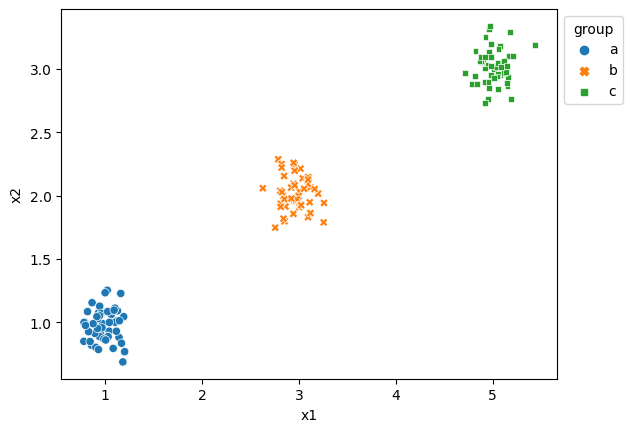

In [49]:
make_scatterplot(df0_125)

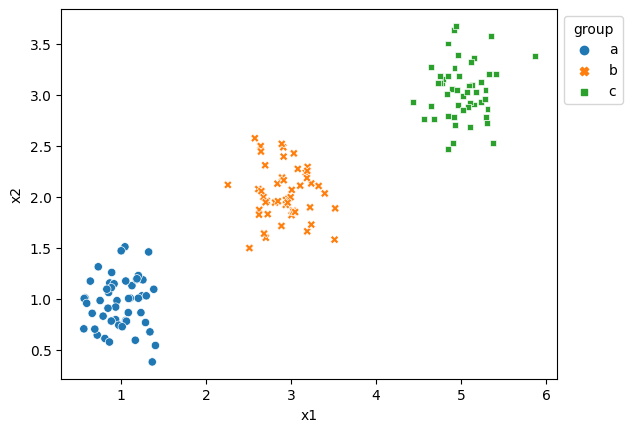

In [50]:
make_scatterplot(df0_25)

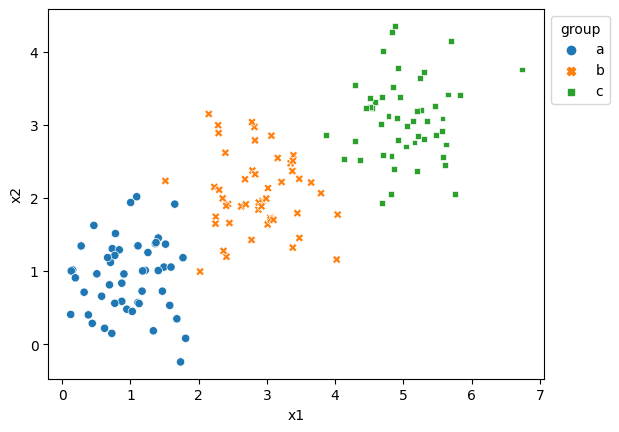

In [51]:
make_scatterplot(df0_5)

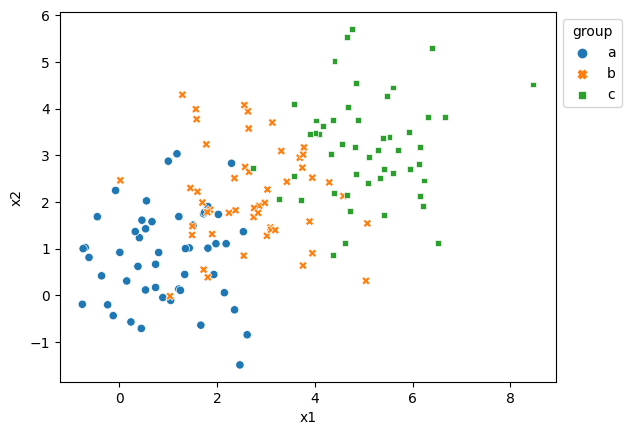

In [52]:
make_scatterplot(df1_0)

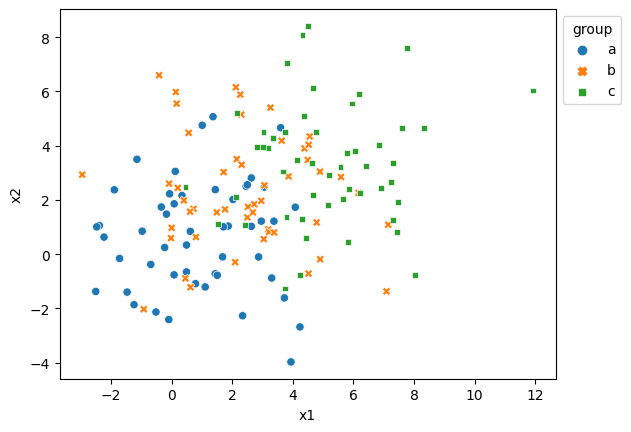

In [53]:
make_scatterplot(df2_0)

As the noise goes up from 0.125 to 2, the visual distinctiveness of the clusters decreases. The groups start to be less tightly clustered, and the different groups start to overlap each other more and more. At a noise level of 2, it's hard to tell where the center of each group is even supposed to be, though I can still tell that group c tends to have slightly higher x1 values than the other two groups.

In [54]:
# this code mostly taken from the kMC jupyter notebook in the DS3001 GitHub repo

from sklearn.cluster import KMeans

def make_scree_plot(df):
  X = df.loc[ : , ['x1','x2'] ]
  X = X.apply(maxmin) # apply normalization function

  # Create a scree plot:
  k_bar = 10
  k_grid = np.arange(1,k_bar+1)
  SSE = np.zeros(k_bar) # training error
  for k in range(k_bar):
      model = KMeans(n_clusters=k+1, max_iter=300, n_init = 10, random_state=0)
      model = model.fit(X)
      SSE[k] = model.inertia_ # Record the sum of squared error for k in the SSE vector

  scree_plot = sns.lineplot(x=k_grid, y=SSE).set_title('Scree Plot') # Create scree plot

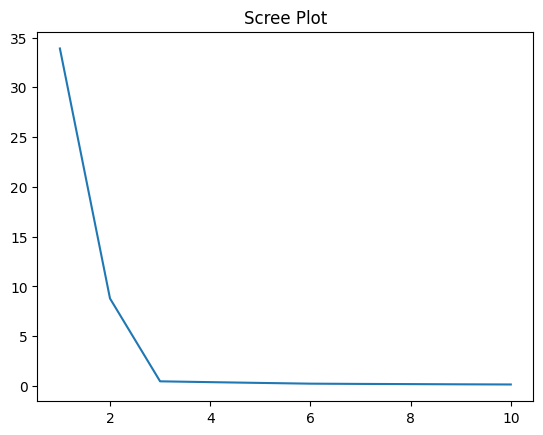

In [56]:
make_scree_plot(df0_125)

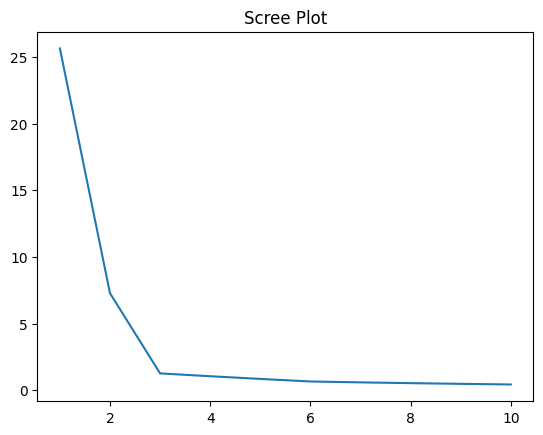

In [58]:
make_scree_plot(df0_25)

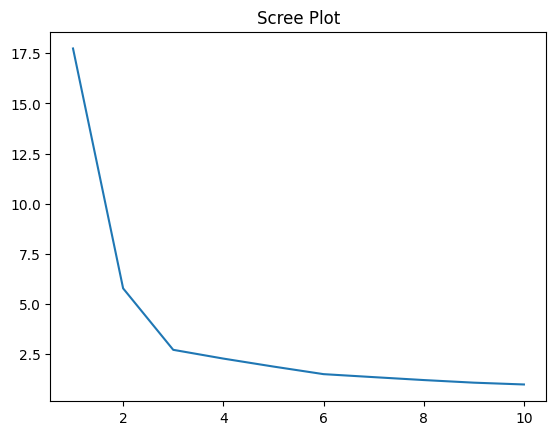

In [59]:
make_scree_plot(df0_5)

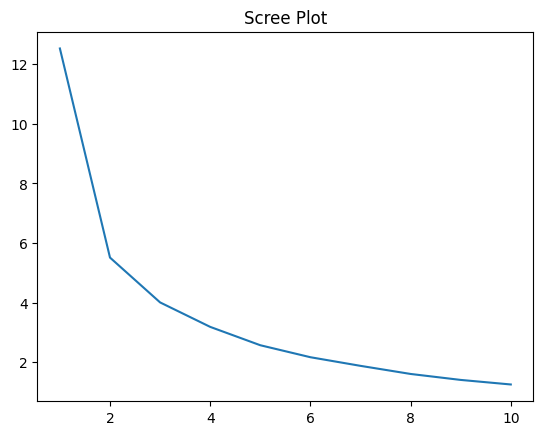

In [60]:
make_scree_plot(df1_0)

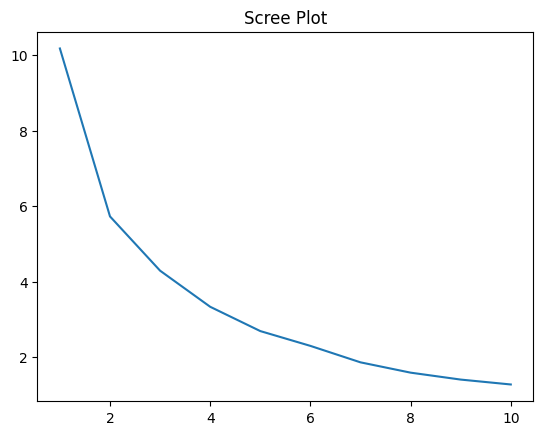

In [61]:
make_scree_plot(df2_0)

In [ ]:
# Explain the intuition of the elbow, using this numerical simulation as an example.

The intuition of the elbow is to identify when increasing the value of k stops becoming useful. As k increases, the number of groups increases -- eventually, when k equals the sample size, each data point will be in its own group, thus having a perfect fit. However, that would certainly be overfitting to the data. Instead, we can look at how much of an improvement we get every time we increase k. When the improvement levels out, we know that any increase in k is not going to be super helpful, and will probably contribute to overfitting. This "leveling off" point is the elbow. If we don't see a distinct elbow, that means that we have continuous improvement in model performance as we increase the k.

We can see this idea illustrated with the example datasets above. For the first few datasets (the less noisy ones), the scree plots show a distinct elbow at 3. That makes sense, because these datasets do indeed have three groups. However, as the data get noisier and noisier, the elbow becomes less and less distinct. Eventually, with the most noisy dataset, the scree plot almost looks like a smooth curve. This makes sense because the three groups overlap each other significantly in this dataset, which means that k means clustering will naturally make lots of mistakes. Therefore, the model will continue to improve as the number of groups gets bigger, and there won't be an obvious elbow.

**Q7.** We looked at computer vision with $k$NN in a previous question. Can $k$ means clustering correctly group digits, even if we don't know which symbols are which?

1. To load the data, run the following code in a chunk:
```
from keras.datasets import mnist
df = mnist.load_data('minst.db')
train,test = df
X_train, y_train = train
X_test, y_test = test
```
The `y_test` and `y_train` vectors, for each index `i`, tell you want number is written in the corresponding index in `X_train[i]` and `X_test[i]`. The value of `X_train[i]` and `X_test[i]`, however, is a 28$\times$28 array whose entries contain values between 0 and 256. Each element of the matrix is essentially a "pixel" and the matrix encodes a representation of a number. To visualize this, run the following code to see the first ten numbers:
```
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(edgeitems=30, linewidth=100000)
for i in range(5):
    print(y_test[i],'\n') # Print the label
    print(X_test[i],'\n') # Print the matrix of values
    plt.contourf(np.rot90(X_test[i].transpose())) # Make a contour plot of the matrix values
    plt.show()
```
OK, those are the data: Labels attached to handwritten digits encoded as a matrix.

2. What is the shape of `X_train` and `X_test`? What is the shape of `X_train[i]` and `X_test[i]` for each index `i`? What is the shape of `y_train` and `y_test`?
3. Use Numpy's `.reshape()` method to covert the training and testing data from a matrix into an vector of features. So, `X_test[index].reshape((1,784))` will convert the $index$-th element of `X_test` into a $28\times 28=784$-length row vector of values, rather than a matrix. Turn `X_train` into an $N \times 784$ matrix $X$ that is suitable for scikit-learn's kNN classifier where $N$ is the number of observations and $784=28*28$ (you could use, for example, a `for` loop).
4. Use $k$ means clustering on the reshaped `X_test` data with `k=10`.  
5. Cross tabulate the cluster assignments with the true labels for the test set values. How good is the correspondence? What proportion of digits are clustered correctly? Which digits are the hardest to distinguish from one another? Can $k$MC recover the latent digits 0 to 9, without even knowing what those digits were?
6. If you use a scree plot to determine the number of clusters $k$, does it pick 10 (the true number of digits), or not? If it fails to pick $k=10$, which digits does it tend to combine into the same classification?